In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/kaggle/playground/'

In [4]:
from traitlets.utils.importstring import import_item
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tkinter
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter

In [5]:
train = pd.read_csv(path+'train.csv', index_col='id')
test = pd.read_csv(path+'test.csv', index_col='id')

In [10]:
column_list = list(train.columns)[:-1] # 타겟 값인 Class 제외 컬럼명 리스트로 받기기

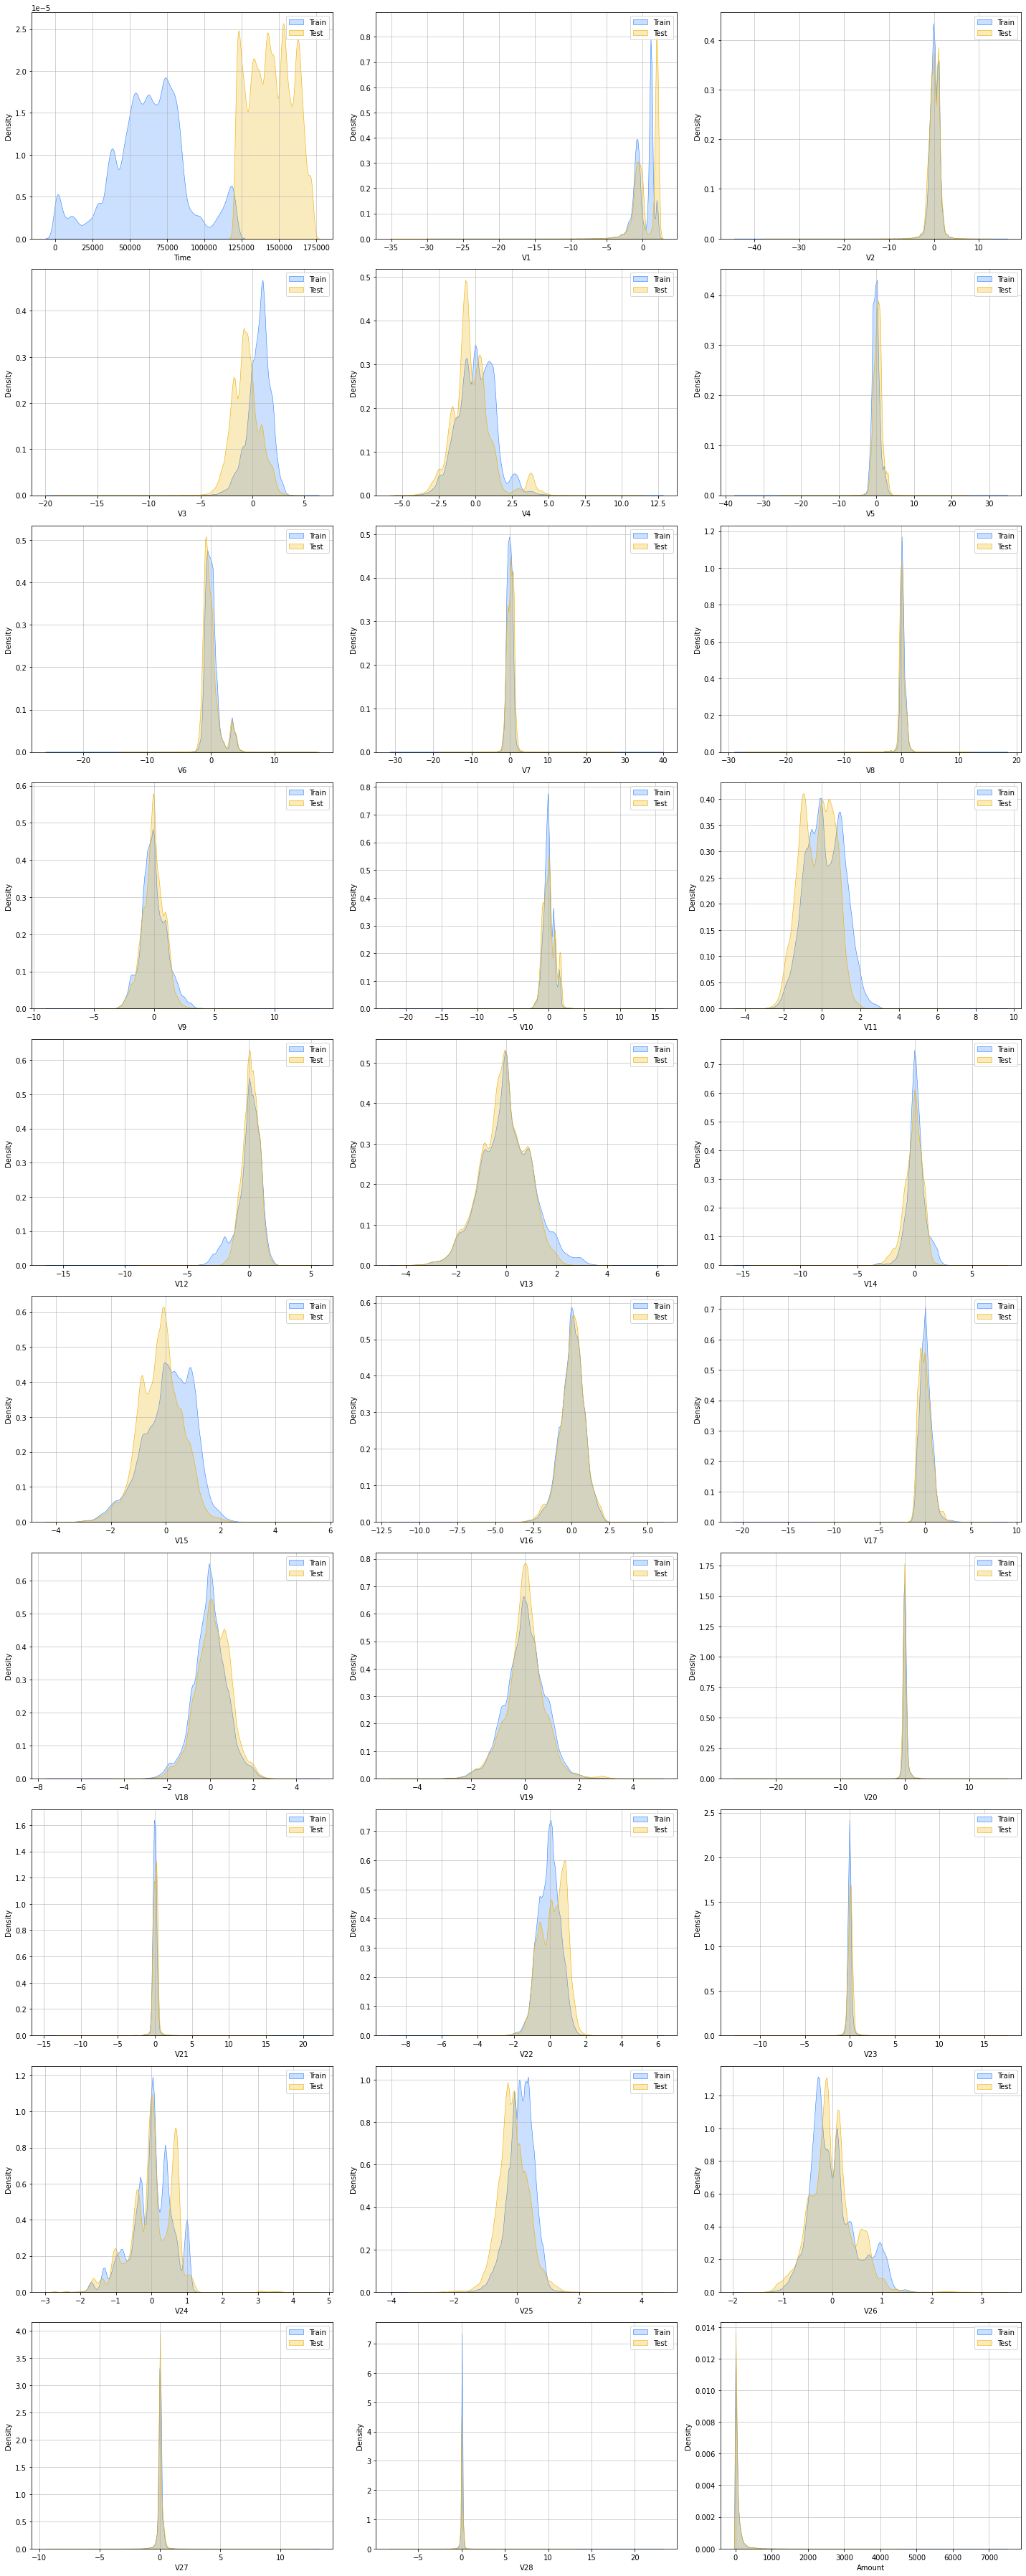

In [13]:
# train과 test 데이터 유사성 파악하기
fig = plt.figure(figsize = (20,50))
rows, cols = 10, 3
for idx, num in enumerate(column_list):
  ax = fig.add_subplot(rows, cols, idx+1)
  ax.grid(alpha = 0.7, axis = 'both')
  sns.kdeplot(x = num, fill = True, color = '#3386FF', linewidth = 0.6, data = train, label = 'Train')
  sns.kdeplot(x = num, fill = True, color = '#EFB000', linewidth = 0.6, data = test, label = 'Test')
  ax.set_xlabel(num)
  ax.legend()
fig.tight_layout()
fig.show()
# Time 컬럼만 좀 많이 다르다는 것 확인 가능능

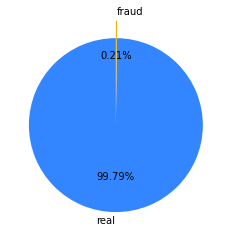

In [16]:
color = ['#3386FF',"#EFB000"]
l1 = list(train['Class'].value_counts())
pie_values = [l1[0]/sum(l1)*100, l1[1]/sum(l1)*100] # imbalance 데이터를 파이 차트로 확인하기
plt.pie(pie_values, labels = ['real','fraud'],
        autopct = '%1.2f%%',
        startangle = 90,
        explode = (0.1,0.1),
        colors = color)
plt.show()

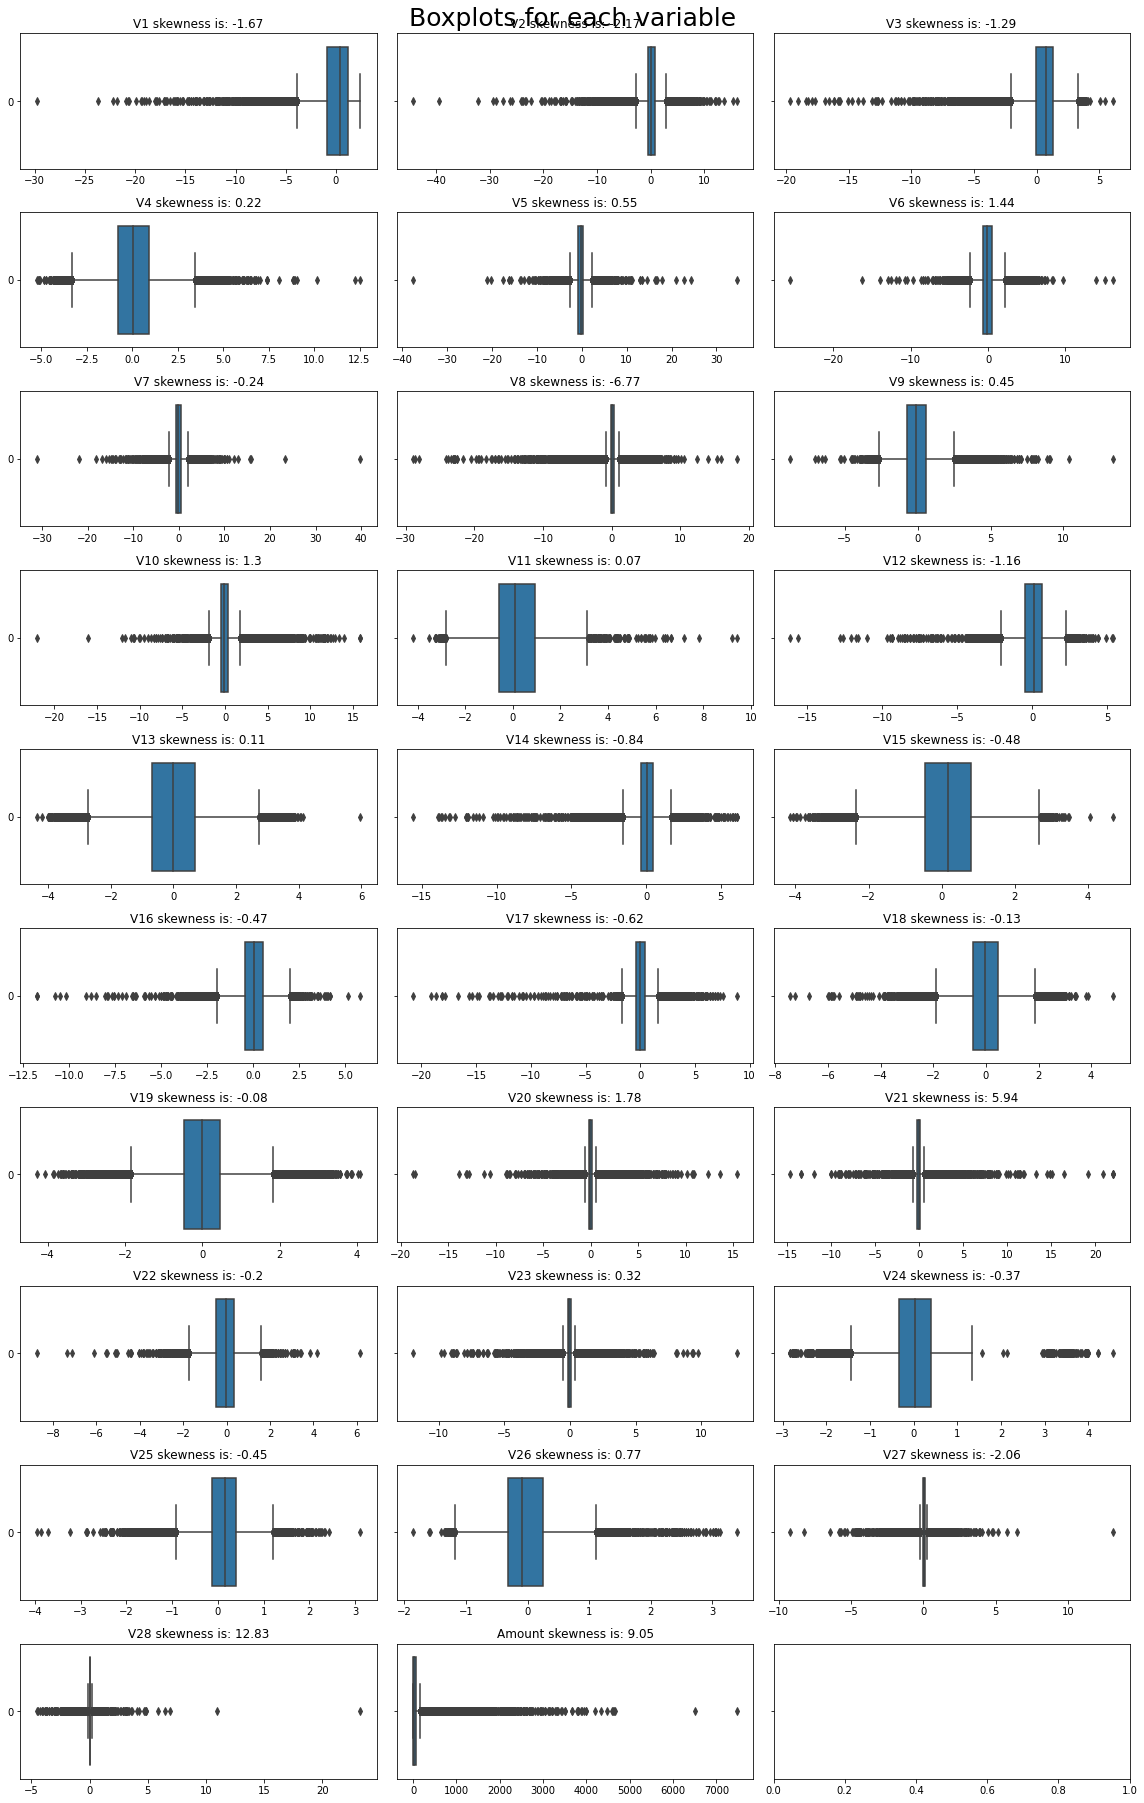

In [19]:
# Time 데이터를 제외한 것으로 이상치 분포 확인
numeric_column = column_list[1:]
# boxplot으로 이상치 확인
def boxplots(dataset, column_lists, rows, cols, subtitle):
  fig, axs = plt.subplots(rows, cols, sharey = True, figsize = (16,25))
  fig.suptitle(subtitle, y = 1, size = 25)
  axs = axs.flatten()
  for i, data in enumerate(column_lists):
    sns.boxplot(data = dataset[data], orient = 'h', ax = axs[i])
    axs[i].set_title(data + ' skewness is: ' + str(round(dataset[data].skew(axis = 0, skipna = True),2))) #왜도 확인
# skewness 왜도는 얼마나 대칭적인지 확인하는 척도로, 완전히 대칭적일 때 0이 됨.
boxplots(dataset = train, column_lists = numeric_column, rows = 10, cols = 3, subtitle = 'Boxplots for each variable')
plt.tight_layout()

#outlier 가 많고, 왜도가 크다는 것이 확인 가능능

In [24]:
# IQR 이용해 outlier 확인하기
def IQR_method(df, n, features):
  outlier_list = []
  for column in features:
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outlier_list_column = df[(df[column]<Q1-outlier_step) | (df[column]>Q3 + outlier_step)].index
    outlier_list.extend(outlier_list_column)

  outlier_list = Counter(outlier_list)
  multiple_outliers = list(k for k, v in outlier_list.items() if v>n)
  out1 = df[df[column]<Q1- outlier_step]
  out2 = df[df[column]>Q3 + outlier_step]

  print('total number of deleted outliers is :', out1.shape[0] + out2.shape[0])
  return multiple_outliers

# IQR 벗어난 이상치 값 제외시키기
outlier_IQR = IQR_method(df = train, n = 1, features = numeric_column)
df_out = train.drop(outlier_IQR, axis = 0).reset_index(drop = True)

total number of deleted outliers is : 20617


In [25]:
print ('The amount of frauds in df before dropping outliers: ', len(train[train['Class'] == 1]))
print ('The amount of frauds in df after dropping outliers: ', len(df_out[df_out['Class'] == 1]))
# 생각보다 많은 것이 drop이 되었기에 사용을 해서는 안됨!

The amount of frauds in df before dropping outliers:  469
The amount of frauds in df after dropping outliers:  188


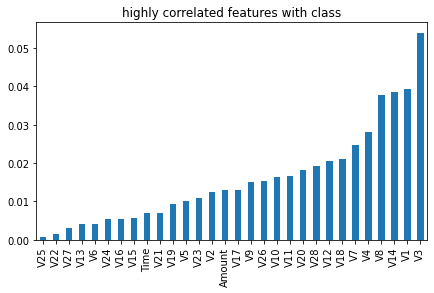

In [26]:
plt.figure(figsize = (7,4))
train.corr()['Class'][:-1].abs().sort_values().plot(kind = 'bar', title = 'highly correlated features with class')